<a href="https://colab.research.google.com/github/gabriellabarcinas/EyeLead/blob/main/Fashion_MNIST_ex.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Writeup

For the writeup, please include the following information:


*   Describe the architecture of your neural network
*   Discuss how you tuned your network and why you think it's performance is reasonable for this task
*   Discuss wether or not you feel that this classifier is appropriate for the given task (check PA3 description)



In [ ]:
# The architecture that we used was as a convolutional neural network model involving 
# a single convolutional and max pooling layer. The convolutional layer has 32 filters 
# with a filter size of 3x3. The neural network consists of one hidden layer with 100 nodes.
# All layers utilize the relu activation function. We tuned our network to have 10 epochs 
# because we found that for this specific dataset, the model began to plateau at this number. 
# Additionally, the learning rate was set to 0.001 because it did not allow the model to converge
# too quickly and training at a slower rate fit more for this dataset as we played around with it.
# This classifier is appropriate for this given task because the model has a 91.58% test accuracy that
# is sufficient enough to classify images of clothes to assist in the return process at a shipping 
# facility.

# PyTorch

## 0 Imports

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## 1. Set Hyperparameters

In [16]:
# You can modify these values

# n_epochs = 15
# batch_size_train = 64
# batch_size_test = 1000
# learning_rate = 0.01
# momentum = 0.6
# log_interval = 100

n_epochs = 15
batch_size_train = 64
batch_size_test = 1000
learning_rate = 0.001
momentum = 0.4
log_interval = 100

## 2. Load Data

In [3]:
train_set = torchvision.datasets.FashionMNIST(
  root = './data/FashionMNIST',
  train = True,
  download = True,
  transform = transforms.Compose([
      transforms.ToTensor()                                 
  ]))

train_loader = torch.utils.data.DataLoader(train_set,
                                     batch_size = batch_size_train,
                                     shuffle=True)

train_set = torchvision.datasets.FashionMNIST(
  root = './data/FashionMNIST',
  train = False,
  download = True,
  transform = transforms.Compose([
      transforms.ToTensor()                                 
  ]))

test_loader = torch.utils.data.DataLoader(train_set,
                                     batch_size = batch_size_train,
                                     shuffle=True)

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/FashionMNIST/raw



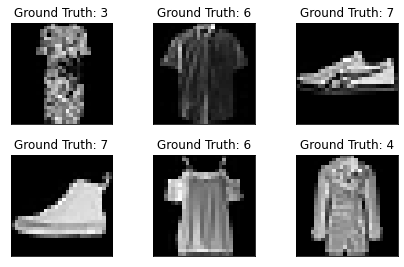

In [4]:
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)

fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Ground Truth: {}".format(example_targets[i]))
  plt.xticks([])
  plt.yticks([])

In [5]:
INPUT_CHANNELS = example_data.shape[1]
OUTPUT_CLASSES = 10
example_data.shape

torch.Size([64, 1, 28, 28])

## 3. Define Model

In [6]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Your code goes here
        self.conv1 = nn.Conv2d(INPUT_CHANNELS, 32, 3)
        self.maxPooling = nn.MaxPool2d(2)
        self.fc1 = nn.Linear(5408, 100)
        self.fc2 = nn.Linear(100, OUTPUT_CLASSES)
    
    def forward(self, x):
        # And here
        x = self.conv1(x)
        x = self.maxPooling(x)
        linearize = nn.Flatten()
        x = linearize(x)
        x = self.fc1(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output

In [7]:
net = Net().to(device)
net

Net(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (maxPooling): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=5408, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=10, bias=True)
)

## 4. Train Model

In [8]:
train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]

optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=momentum)
criterion = nn.MSELoss()

In [9]:
def train(model, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data = data.to(device)
        target = target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))


def test(model, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data = data.to(device)
            target = target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

In [17]:
for epoch in range(1, n_epochs + 1):
  train(net, train_loader, optimizer, epoch)
  test(net, test_loader)

Train Epoch: 1 [0/60000 (0%)]	Loss: 0.252448
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.262928
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.210209
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.219942
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.242313
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.239482
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.089470
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.246096
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.287622
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.190041

Test set: Average loss: 0.2945, Accuracy: 8969/10000 (90%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.299096
Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.127204
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.160501
Train Epoch: 2 [19200/60000 (32%)]	Loss: 0.179463
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.150116
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.184440
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.204663
Train Epoch: 2 [44800/60000 (75%)]	Loss: 0.153734
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.178560
T

# Tensorflow

## 0. Imports

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds

## 1. Set Hyperparameters

In [2]:
# Tune these

n_epochs = 10
batch_size_train = 64
batch_size_test = 1000
learning_rate = 0.001

## 2. Import Data

In [3]:
(ds_train, ds_test), ds_info = tfds.load(
    'fashion_mnist',
    split=['train', 'test'],
    shuffle_files=True,
    as_supervised=True,
    with_info=True,
)

def normalize_img(image, label):
  """Normalizes images: `uint8` -> `float32`."""
  return tf.cast(image, tf.float32) / 255., label

ds_train = ds_train.map(
    normalize_img, num_parallel_calls=tf.data.AUTOTUNE)
ds_train = ds_train.cache()
ds_train = ds_train.shuffle(ds_info.splits['train'].num_examples)
ds_train = ds_train.batch(batch_size_train)
ds_train = ds_train.prefetch(tf.data.AUTOTUNE)

ds_test = ds_test.map(
    normalize_img, num_parallel_calls=tf.data.AUTOTUNE)
ds_test = ds_test.batch(batch_size_test)
ds_test = ds_test.cache()
ds_test = ds_test.prefetch(tf.data.AUTOTUNE)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/60000 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/fashion_mnist/3.0.1.incomplete2NF7OG/fashion_mnist-train.tfrecord*...:   0%|  …

Generating test examples...:   0%|          | 0/10000 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/fashion_mnist/3.0.1.incomplete2NF7OG/fashion_mnist-test.tfrecord*...:   0%|   …

Dataset fashion_mnist downloaded and prepared to ~/tensorflow_datasets/fashion_mnist/3.0.1. Subsequent calls will reuse this data.


## 3. Define Model

In [4]:
model = tf.keras.models.Sequential([
  ## Your architecture goes here
  tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(28, 28, 1)),
  tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(100, activation='relu'),
  tf.keras.layers.Dense(10, activation='softmax')
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()],
)

## 4. Train Model

In [5]:
model.fit(
    ds_train,
    epochs=n_epochs,
    validation_data=ds_test,
)

Epoch 1/10


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


938/938 [==============================] - 21s 5ms/step - loss: 0.4301 - sparse_categorical_accuracy: 0.8481 - val_loss: 0.3446 - val_sparse_categorical_accuracy: 0.8756
Epoch 2/10
938/938 [==============================] - 3s 4ms/step - loss: 0.2907 - sparse_categorical_accuracy: 0.8947 - val_loss: 0.3160 - val_sparse_categorical_accuracy: 0.8858
Epoch 3/10
938/938 [==============================] - 4s 4ms/step - loss: 0.2477 - sparse_categorical_accuracy: 0.9101 - val_loss: 0.2725 - val_sparse_categorical_accuracy: 0.8994
Epoch 4/10
938/938 [==============================] - 3s 4ms/step - loss: 0.2191 - sparse_categorical_accuracy: 0.9201 - val_loss: 0.2749 - val_sparse_categorical_accuracy: 0.8996
Epoch 5/10
938/938 [==============================] - 3s 4ms/step - loss: 0.1944 - sparse_categorical_accuracy: 0.9281 - val_loss: 0.2714 - val_sparse_categorical_accuracy: 0.8994
Epoch 6/10
938/938 [==============================] - 3s 4ms/step - loss: 0.1720 - sparse_categorical_accuracy